<a href="https://colab.research.google.com/github/machiwao/CCTHESS1-CCTHESS2-Dev-and-Docs/blob/jessy/NDWI_data_scraping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install earthengine-api geemap scipy

In [ ]:
import ee
import geemap
import pandas as pd
from scipy.signal import savgol_filter
import os

In [ ]:
cloud_project = 'heat-index-forecasting'

try:
  ee.Initialize(project=cloud_project)
except:
  ee.Authenticate()
  ee.Initialize(project=cloud_project)

stations = {
    "Sinait": ee.Geometry.Point([120.459762, 17.89019]).buffer(25000),
    "Tayabas": ee.Geometry.Point([121.596575, 14.018428]).buffer(25000),
    "Tanay": ee.Geometry.Point([121.36927, 14.581167]).buffer(25000),
    "Tuguegarao": ee.Geometry.Point([121.758469, 17.647678]).buffer(25000),
    "Virac": ee.Geometry.Point([124.209834, 13.576558]).buffer(25000),
}

start_date = "2014-01-01"
end_date   = "2024-01-01"


In [ ]:
def get_hls_collection(region, start_date, end_date):
    # Landsat HLS
    hls_landsat = (
        ee.ImageCollection("NASA/HLS/HLSL30/v002")
        .filterBounds(region)
        .filterDate(start_date, end_date)
        .map(lambda img: img.select(["B3", "B5"])  # Green = B3, NIR = B5
                         .multiply(0.0001)
                         .rename(["GREEN", "NIR"])
                         .copyProperties(img, img.propertyNames()))
    )

    # Sentinel-2 HLS
    hls_sentinel = (
        ee.ImageCollection("NASA/HLS/HLSS30/v002")
        .filterBounds(region)
        .filterDate(start_date, end_date)
        .map(lambda img: img.select(["B3", "B8"])  # Green = B3, NIR = B8
                         .multiply(0.0001)
                         .rename(["GREEN", "NIR"])
                         .copyProperties(img, img.propertyNames()))
    )

    # Merge both collections
    merged = hls_landsat.merge(hls_sentinel)

     # Compute NDWI
    def add_ndwi(img):
        ndwi = img.normalizedDifference(["GREEN", "NIR"]).rename("NDWI")
        return img.addBands(ndwi).select("NDWI")

    return merged.map(add_ndwi)

In [ ]:
def process_station(station_name, geometry, start_date, end_date):
    hls = get_hls_collection(geometry, start_date, end_date)

    print(f"Processing NDWI for {station_name}...")

    ts = hls.map(lambda img: ee.Feature(
        None, {
            "date": img.date().format("YYYY-MM-dd"),
            "NDWI": img.reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=geometry,
                scale=30,
                bestEffort=True,
                maxPixels=1e9
            ).get("NDWI")
        }
    ))

    df = geemap.ee_to_df(ee.FeatureCollection(ts))

    if df.empty:
        print(f"No data for {station_name}")
        return df

    # Process time series
    df["date"] = pd.to_datetime(df["date"])
    df = df.sort_values("date").groupby("date").mean().reset_index()

    # Reindex to daily
    full_range = pd.date_range(start=start_date, end=end_date, freq="D")
    g = df.set_index("date").reindex(full_range)
    g.index.name = "date"
    g = g.reset_index()

    # Preserve original
    g["NDWI_original"] = g["NDWI"]

    # Interpolate missing values
    g["NDWI_linear"] = g["NDWI"].interpolate("linear", limit_direction="both")
    g["NDWI_spline"] = g["NDWI"].interpolate("spline", order=3, limit_direction="both")

    # Save to CSV
    out_file = f"{station_name}_NDWI.csv"
    g[["date", "NDWI_original", "NDWI_linear", "NDWI_spline"]].to_csv(out_file, index=False)

    print(f"Saved {out_file} ({g.shape[0]} rows)")
    return g

In [ ]:
all_dfs = {}
for station, geom in stations.items():
    all_dfs[station] = process_station(station, geom, start_date, end_date)

Processing NDWI for Sinait...
Saved Sinait_NDWI.csv (3653 rows)
Processing NDWI for Tayabas...
Saved Tayabas_NDWI.csv (3653 rows)
Processing NDWI for Tanay...
Saved Tanay_NDWI.csv (3653 rows)
Processing NDWI for Tuguegarao...
Saved Tuguegarao_NDWI.csv (3653 rows)
Processing NDWI for Virac...
Saved Virac_NDWI.csv (3653 rows)


In [ ]:
# Check the first few rows of one of the dataframes
if all_dfs:
    first_station = list(all_dfs.keys())[0]
    print(f"First values for {first_station}:")
    display(all_dfs[first_station].head())
else:
    print("No dataframes were processed.")

First values for Sinait:


,date,NDWI,NDWI_original,NDWI_linear,NDWI_spline
0,2014-01-01,NaN,NaN,-0.357553,-0.178050
1,2014-01-02,NaN,NaN,-0.357553,-0.178230
2,2014-01-03,NaN,NaN,-0.357553,-0.178411
3,2014-01-04,NaN,NaN,-0.357553,-0.178591
4,2014-01-05,NaN,NaN,-0.357553,-0.178771


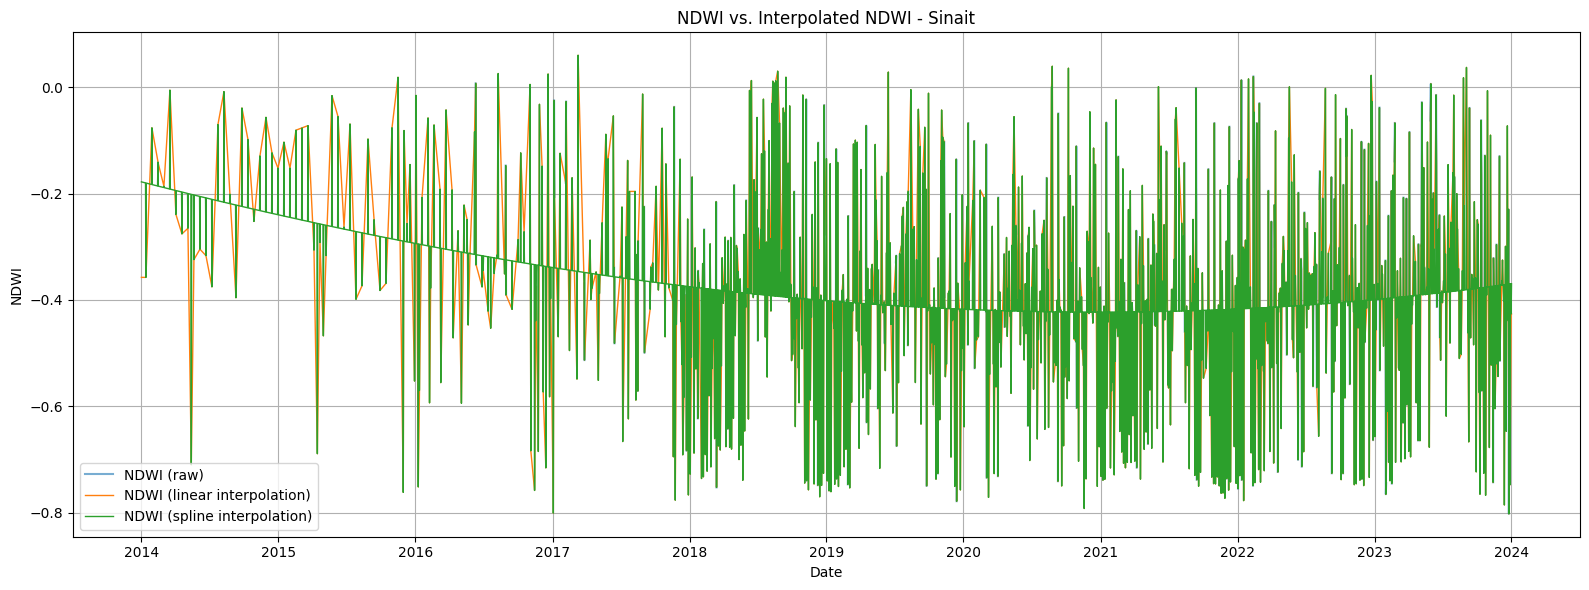

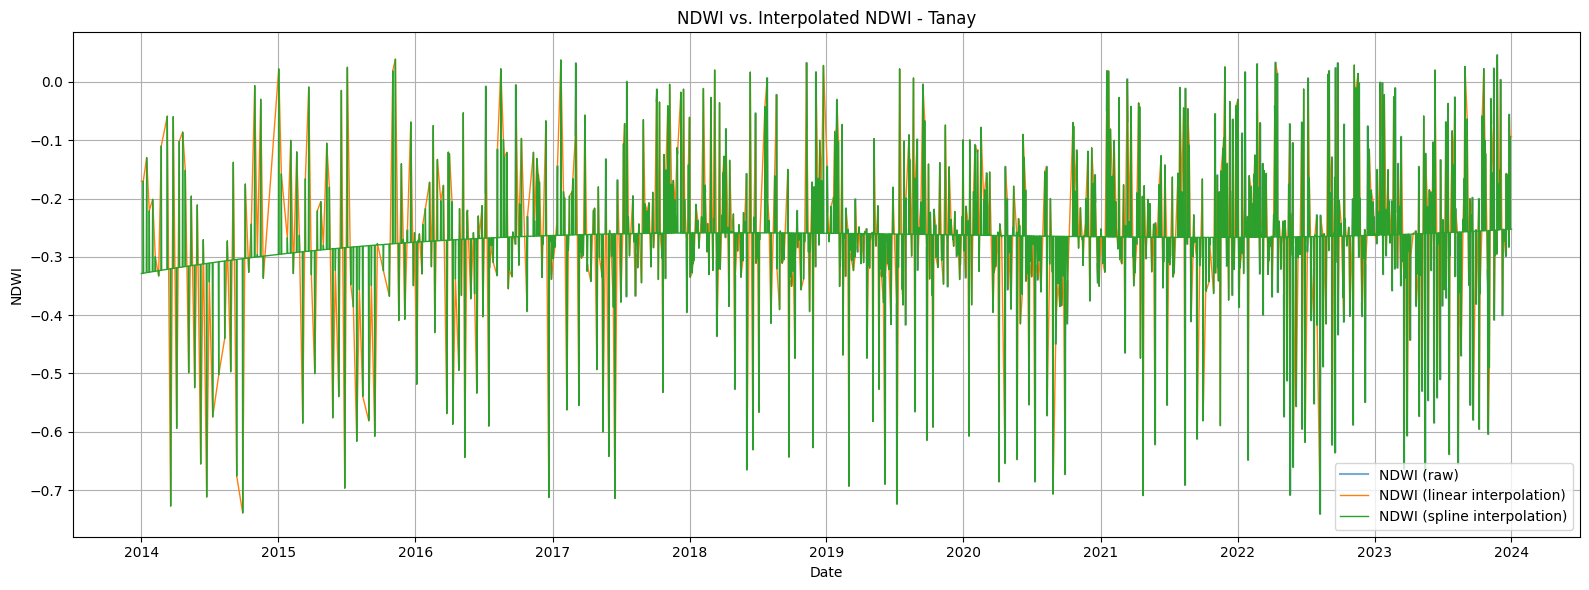

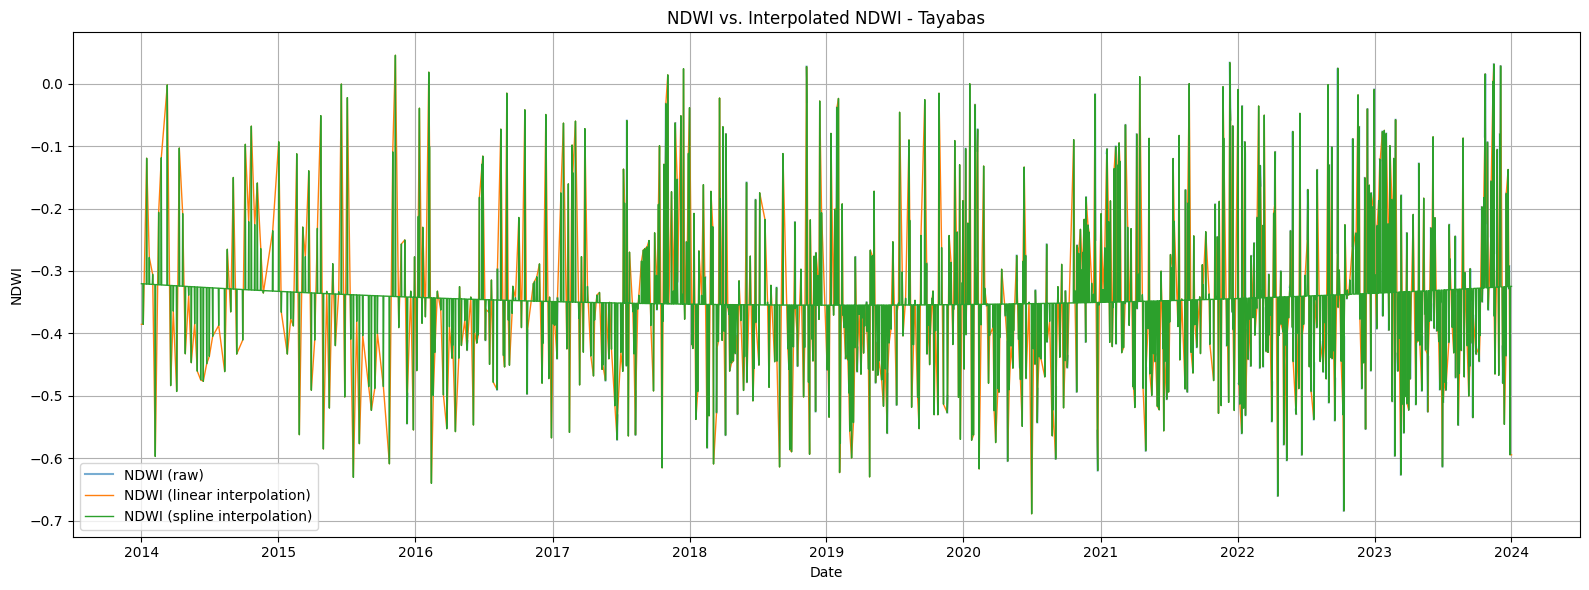

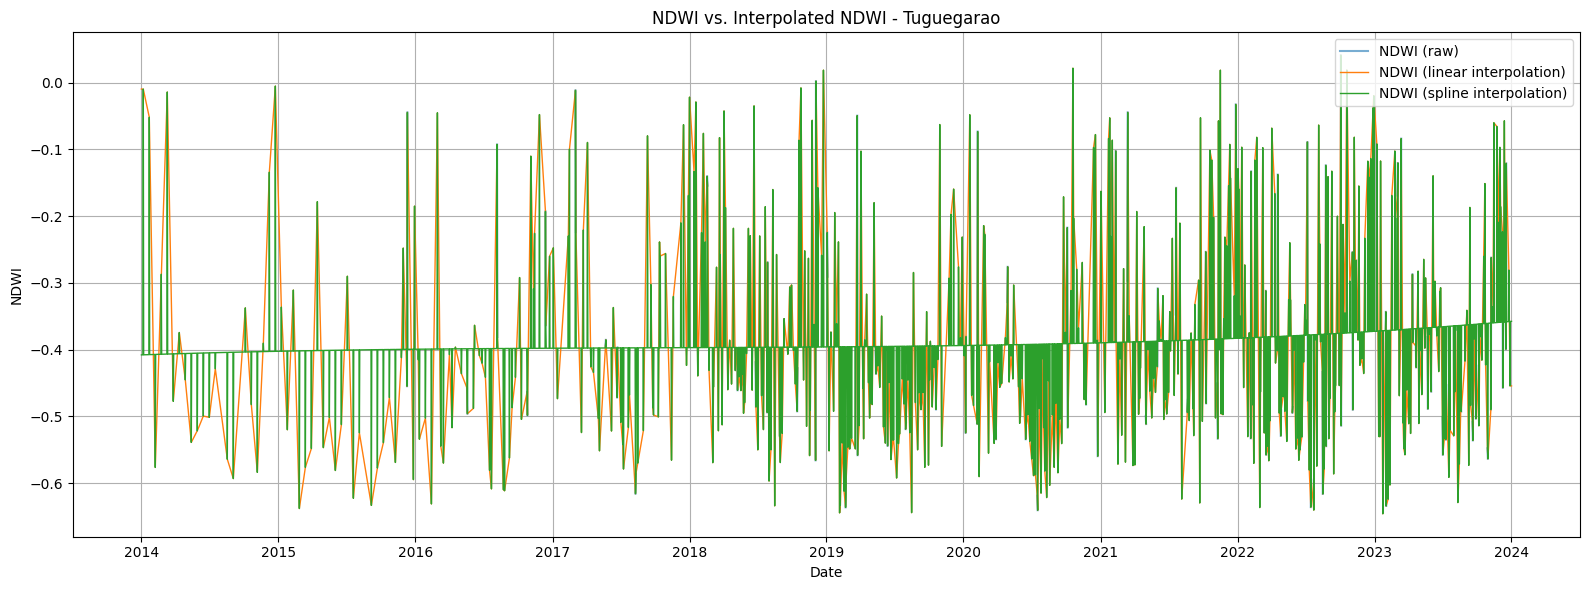

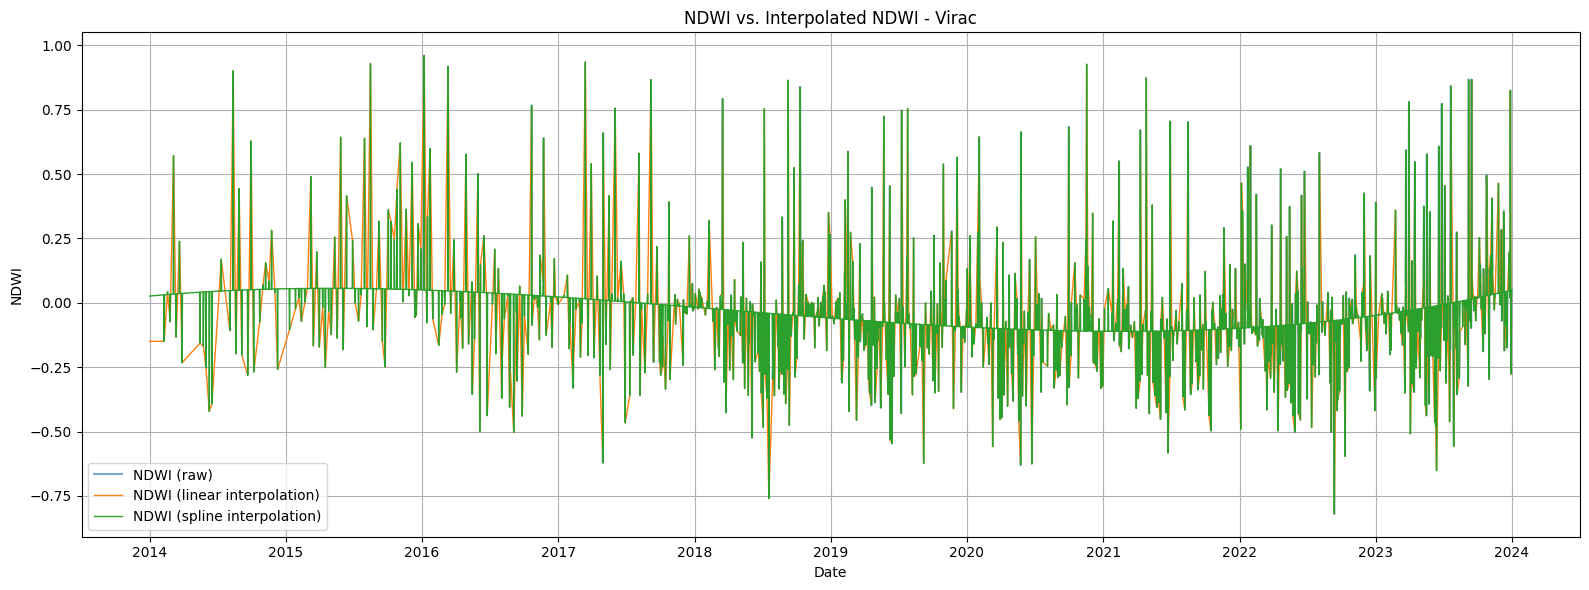

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_values(csv_file, station_name):
    # Load CSV (expects columns: date, NDWI_original, NDWI_linear, NDWI_spline)
    df = pd.read_csv(csv_file, parse_dates=["date"])

    # Plot
    plt.figure(figsize=(16, 6))
    plt.plot(df["date"], df["NDWI_original"], label="NDWI (raw)", alpha=0.6)
    plt.plot(df["date"], df["NDWI_linear"], label="NDWI (linear interpolation)", linewidth=1)
    plt.plot(df["date"], df["NDWI_spline"], label="NDWI (spline interpolation)", linewidth=1)


    plt.xlabel("Date")
    plt.ylabel("NDWI")
    plt.title(f"NDWI vs. Interpolated NDWI - {station_name}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

station_names = ["Sinait", "Tanay", "Tayabas", "Tuguegarao", "Virac"]
for station in station_names:
    csv_file = f"{station}_NDWI.csv"
    plot_values(csv_file, station)